### Installing the dependencies

In [1]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms, models
from torchsummary import summary
from tqdm import tqdm 
from pathlib import Path
from torch.optim.lr_scheduler import  _LRScheduler, ReduceLROnPlateau,StepLR

### Getting to know the data

In [2]:
os.chdir("../artifacts/data_ingestion")

In [3]:
os.getcwd()

'c:\\Users\\49179\\Desktop\\Food_image_classification\\artifacts\\data_ingestion'

In [4]:
data_path = Path(os.getcwd())
image_path = data_path/"food_40_percent"

In [5]:
import os
def walk_thru_dir(dir_path):
    for dirpath,dirname, filenames in os.walk(dir_path):
        print(f"There are {len(dirname)} directories and {len(filenames)} images in {Path(dirpath).name}")
walk_thru_dir(image_path)

There are 2 directories and 0 images in food_40_percent
There are 20 directories and 0 images in test
There are 0 directories and 100 images in beet_salad
There are 0 directories and 100 images in bruschetta
There are 0 directories and 100 images in cheesecake
There are 0 directories and 100 images in chocolate_cake
There are 0 directories and 100 images in fried_rice
There are 0 directories and 100 images in frozen_yogurt
There are 0 directories and 100 images in garlic_bread
There are 0 directories and 100 images in gnocchi
There are 0 directories and 100 images in grilled_cheese_sandwich
There are 0 directories and 100 images in macaroni_and_cheese
There are 0 directories and 100 images in nachos
There are 0 directories and 100 images in pancakes
There are 0 directories and 100 images in ravioli
There are 0 directories and 100 images in samosa
There are 0 directories and 100 images in spring_rolls
There are 0 directories and 100 images in strawberry_shortcake
There are 0 directories

In [6]:
class_path = list(image_path.glob("*/*"))
class_names = [item.name for item in (class_path)][:20]

In [7]:
class_names,len(class_names)

(['beet_salad',
  'bruschetta',
  'cheesecake',
  'chocolate_cake',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'grilled_cheese_sandwich',
  'macaroni_and_cheese',
  'nachos',
  'pancakes',
  'ravioli',
  'samosa',
  'spring_rolls',
  'strawberry_shortcake',
  'tacos',
  'takoyaki',
  'tiramisu',
  'waffles'],
 20)

In [8]:
train_dir = image_path/"train"
test_dir = image_path/"test"

### Visualization of data

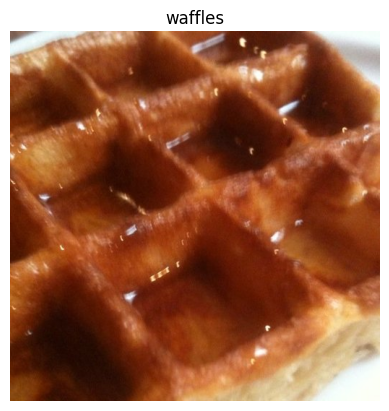

In [9]:
# Visulaizing the random images

def show_random_images(path, class_name):
    target_dir =  path/class_name
    image_path_list = list(target_dir.glob("*.jpg"))
    random_image_path = random.choice(image_path_list)

    img = mpimg.imread(random_image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(random_image_path.parent.stem)
    
show_random_images(train_dir, "waffles")

### Transforming the data

In [10]:
train_transforms =  transforms.Compose([transforms.Resize(size=(224,224)),
                                                                      transforms.CenterCrop(size=(224,224)),
                                                                      transforms.RandomRotation(degrees=10),
                                                                      transforms.RandomVerticalFlip(True),
                                                                      transforms.ColorJitter(brightness=0.2,contrast=0.2, saturation=0.2, hue=0.1),
                                                                      transforms.RandomHorizontalFlip(True),
                                                                      transforms.GaussianBlur(kernel_size=3),
                                                                      transforms.RandomAffine(degrees=20, translate=(0.1,0.2),shear=20, scale=(0.8,1.2)),
                                                                      transforms.ToTensor(),
                                                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])


test_transforms =  transforms.Compose([transforms.Resize(size=(256,256)),
                                    transforms.CenterCrop(size=(224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [11]:
train_data = datasets.ImageFolder(train_dir,transform= train_transforms)
test_data = datasets.ImageFolder(test_dir,transform=test_transforms)

In [12]:
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size

In [13]:
train_data, val_data = random_split(train_data,[train_size, val_size])

In [14]:
train_dataloader = DataLoader(dataset=train_data,batch_size=32, shuffle= True, pin_memory=True, num_workers=2)
val_dataloader = DataLoader(dataset=val_data, batch_size= 32, shuffle = False, pin_memory = True, num_workers=2)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False, pin_memory=True, num_workers=os.cpu_count())


In [15]:
val_dataloader

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
model = models.resnet101(weights='DEFAULT').to(device)

In [18]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
for params in model.parameters():
    params.requires_grad = False

for params in model.layer4.parameters():
    params.requires_grad = True

for params in model.fc.parameters():
    params.requires_grad = True

In [20]:
model.fc = torch.nn.Sequential(torch.nn.Dropout(p=0.7, inplace=True),
    torch.nn.Linear(in_features=model.fc.in_features, out_features= 20))
                            

In [21]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
loss_function = nn.CrossEntropyLoss()
def train_step(optimizer):

    model.train()

    train_loss, train_accuracy =0,0
    ProgressBar = tqdm(train_dataloader)


    for batch, (data, label) in enumerate(ProgressBar):
        data, label = data.to(device), label.to(device)

        #forward pass
        y_pred = model(data)

        # Calculate the loss 
        loss = loss_function(y_pred, label)
        train_loss += loss.item()

        #setting optimizer to zero grad
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Calculate the accuracy
        target_predict = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_accuracy += (target_predict == label).sum().item()/len(y_pred)

    train_loss = train_loss/len(train_dataloader)
    train_accuracy = train_accuracy/len(train_dataloader)

    return train_loss, train_accuracy
    


def test_step():

    model.eval()

    val_loss, val_accuracy =0,0
    ProgressBar = tqdm(val_dataloader)
    with torch.inference_mode():
    
        for batch, (data, label) in enumerate(ProgressBar):
            data, label = data.to(device), label.to(device)

            label_pred = model(data)

            #calcuate the loss
            loss = loss_function(label_pred, label)
            val_loss += loss.item()

            # Calculate the accuracy
            target_predict = torch.argmax(torch.softmax(label_pred,dim=1),dim=1)
            val_accuracy += (target_predict == label).sum().item()/len(label_pred)

    val_loss = val_loss/len(val_dataloader)
    val_accuracy = val_accuracy/len(val_dataloader)


    return val_loss,val_accuracy

def initiate_Model_training():
    epochs = 30
    optimizer= torch.optim.Adam(model.parameters(),lr = 0.001, weight_decay=1e-2/epochs)
    #schedular: _LRScheduler = StepLR(optimizer=optimizer,step_size=7, gamma=0.1)

    schedular: _LRScheduler = ReduceLROnPlateau(optimizer=optimizer, mode = "min", factor = 0.1, patience = 5, verbose= True  )
    best_test_loss = float('inf')
    patience = 5
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(1,epochs+1):
        
        train_loss, train_acc = train_step(optimizer=optimizer)
        optimizer.step()
        val_loss,val_accuracy = test_step()
        schedular.step(val_loss)
        print(f" Epoch: {epoch} | Train_loss: {train_loss} | Train_accuracy: {train_acc}| \n |Test_loss: {val_loss} | Test_accuracy: {val_accuracy}|")

        if val_loss < best_test_loss:
            best_test_loss = val_loss
            epochs_no_improve = 0
            best_model = model.state_dict()
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early Stopping")
            early_stop = True
            break

    if early_stop:
        model.load_state_dict(best_model)

    return train_loss, train_acc, val_loss, val_accuracy


In [23]:
initiate_Model_training()

c:\Users\49179\anaconda3\envs\Food\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 38/38 [00:17<00:00,  2.20it/s]


 Epoch: 1 | Train_loss: 1.9677310752868653 | Train_accuracy: 0.41625| 
 |Test_loss: 1.5181142954449904 | Test_accuracy: 0.5518092105263158|


100%|██████████| 38/38 [00:17<00:00,  2.23it/s]


 Epoch: 2 | Train_loss: 1.3064053122202555 | Train_accuracy: 0.6095833333333334| 
 |Test_loss: 1.2331670569746118 | Test_accuracy: 0.6258223684210527|


100%|██████████| 38/38 [00:16<00:00,  2.25it/s]


 Epoch: 3 | Train_loss: 1.0773290399710338 | Train_accuracy: 0.674375| 
 |Test_loss: 1.1737942507392483 | Test_accuracy: 0.6463815789473685|


100%|██████████| 38/38 [00:17<00:00,  2.23it/s]


 Epoch: 4 | Train_loss: 0.9548078342278798 | Train_accuracy: 0.706875| 
 |Test_loss: 1.1077264908112978 | Test_accuracy: 0.6710526315789473|


100%|██████████| 38/38 [00:17<00:00,  2.22it/s]


 Epoch: 5 | Train_loss: 0.8746244585514069 | Train_accuracy: 0.731875| 
 |Test_loss: 1.163498591435583 | Test_accuracy: 0.6661184210526315|


100%|██████████| 38/38 [00:17<00:00,  2.22it/s]


 Epoch: 6 | Train_loss: 0.7776307781537374 | Train_accuracy: 0.7658333333333334| 
 |Test_loss: 1.0849022018282037 | Test_accuracy: 0.6899671052631579|


100%|██████████| 38/38 [00:17<00:00,  2.21it/s]


 Epoch: 7 | Train_loss: 0.7304190068443617 | Train_accuracy: 0.7697916666666667| 
 |Test_loss: 1.1104278831105483 | Test_accuracy: 0.6751644736842105|


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]


 Epoch: 8 | Train_loss: 0.7049784156680107 | Train_accuracy: 0.7847916666666667| 
 |Test_loss: 1.1067324390536861 | Test_accuracy: 0.6883223684210527|


100%|██████████| 38/38 [00:16<00:00,  2.26it/s]


 Epoch: 9 | Train_loss: 0.6575991669297219 | Train_accuracy: 0.8022916666666666| 
 |Test_loss: 1.0346645391301106 | Test_accuracy: 0.696546052631579|


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]


 Epoch: 10 | Train_loss: 0.6192140503724416 | Train_accuracy: 0.8014583333333334| 
 |Test_loss: 1.1384226319036985 | Test_accuracy: 0.6743421052631579|


100%|██████████| 38/38 [00:17<00:00,  2.23it/s]


 Epoch: 11 | Train_loss: 0.5976055337985356 | Train_accuracy: 0.8175| 
 |Test_loss: 1.106525951310208 | Test_accuracy: 0.6833881578947368|


100%|██████████| 38/38 [00:17<00:00,  2.22it/s]


 Epoch: 12 | Train_loss: 0.5748257956902186 | Train_accuracy: 0.825| 
 |Test_loss: 1.1364517243284928 | Test_accuracy: 0.6899671052631579|


100%|██████████| 38/38 [00:18<00:00,  2.02it/s]


 Epoch: 13 | Train_loss: 0.4945335375269254 | Train_accuracy: 0.8395833333333333| 
 |Test_loss: 1.1512253629533868 | Test_accuracy: 0.6907894736842105|


100%|██████████| 38/38 [00:17<00:00,  2.17it/s]

 Epoch: 14 | Train_loss: 0.5034398205081622 | Train_accuracy: 0.8435416666666666| 
 |Test_loss: 1.1044581265825975 | Test_accuracy: 0.6990131578947368|
Early Stopping


(0.5034398205081622,
 0.8435416666666666,
 1.1044581265825975,
 0.6990131578947368)

NameError: name 'train_loss' is not defined